<a href="https://colab.research.google.com/github/AMElashal26/AMElashal26/blob/main/trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance pandas matplotlib


/tmp/ipython-input-3664503932.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


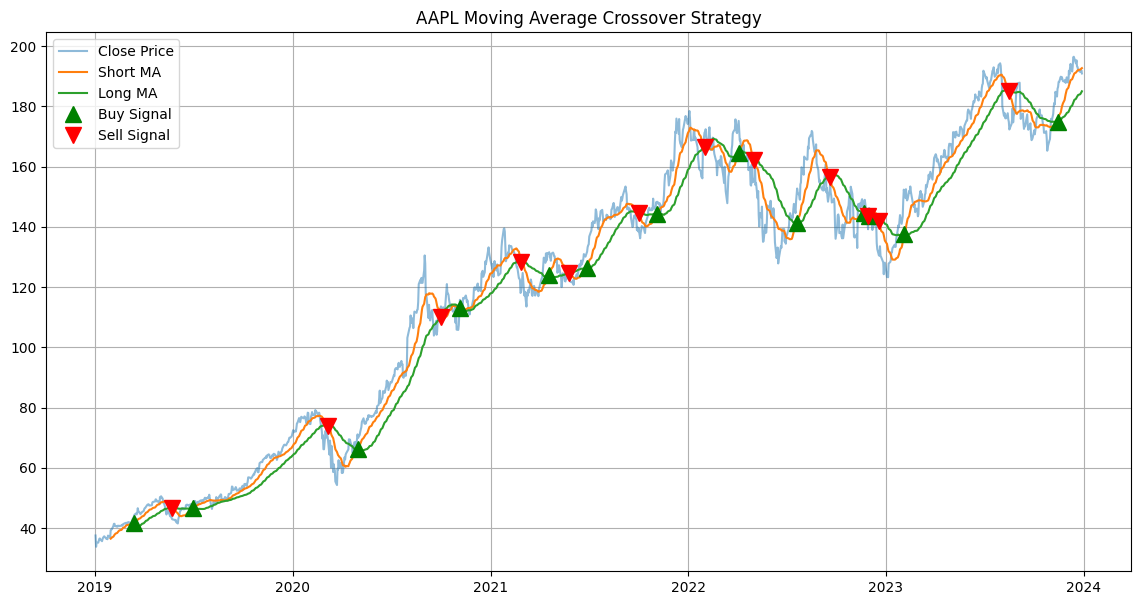

In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
ticker = "AAPL"
start_date = "2019-01-01"
end_date = "2023-12-31"
short_window = 20
long_window = 50

# Fetch data
data = yf.download(ticker, start=start_date, end=end_date)
data = data["Close"].reset_index()
data.columns = ["Date", "Close"]
data["Short_MA"] = data["Close"].rolling(window=short_window).mean()
data["Long_MA"] = data["Close"].rolling(window=long_window).mean()

# Simulate Strategy
data["Signal"] = 0
data.iloc[short_window:, data.columns.get_loc("Signal")] = (
    (data["Short_MA"].iloc[short_window:] > data["Long_MA"].iloc[short_window:]).astype(int)
)
data["Position"] = data["Signal"].diff()

# Visualize signals
plt.figure(figsize=(14, 7))
plt.plot(data["Date"], data["Close"], label="Close Price", alpha=0.5)
plt.plot(data["Date"], data["Short_MA"], label="Short MA")
plt.plot(data["Date"], data["Long_MA"], label="Long MA")
plt.plot(data.loc[data["Position"] == 1, "Date"], data.loc[data["Position"] == 1, "Short_MA"], "^", markersize=12, color='g', label='Buy Signal')
plt.plot(data.loc[data["Position"] == -1, "Date"], data.loc[data["Position"] == -1, "Short_MA"], "v", markersize=12, color='r', label='Sell Signal')
plt.title(f"{ticker} Moving Average Crossover Strategy")
plt.legend()
plt.grid()
plt.show()

In [20]:
stop_loss_pct = 0.05      # 5%
take_profit_pct = 0.10    # 10%

initial_balance = 10000
capital = initial_balance
position = 0
buy_price = 0
in_trade = False
returns = []

for i in range(1, len(data)):
    price = data["Close"].iloc[i]
    prev_price = data["Close"].iloc[i - 1]
    signal = data["Position"].iloc[i]

    # Entry
    if signal == 1 and not in_trade:
        buy_price = price
        position = capital / price
        capital = 0
        in_trade = True

    # Exit logic (normal signal OR stop loss / take profit)
    elif in_trade:
        change = (price - buy_price) / buy_price
        stop_hit = change <= -stop_loss_pct
        take_hit = change >= take_profit_pct

        if signal == -1 or stop_hit or take_hit:
            capital = position * price
            returns.append(change)
            position = 0
            in_trade = False

# Final balance if still in trade
if in_trade:
    capital = position * data["Close"].iloc[-1]
    returns.append((data["Close"].iloc[-1] - buy_price) / buy_price)

# Metrics
total_return = (capital - initial_balance) / initial_balance
win_rate = sum(r > 0 for r in returns) / len(returns) if returns else 0
avg_return = sum(returns) / len(returns) if returns else 0
max_drawdown = min(returns) if returns else 0
sharpe_ratio = avg_return / (pd.Series(returns).std() + 1e-9) * (252**0.5)

print(f"Final Balance:   ${capital:,.2f}")
print(f"Total Return:    {total_return * 100:.2f}%")
print(f"Number of Trades: {len(returns)}")
print(f"Win Rate:        {win_rate * 100:.2f}%")
print(f"Avg Trade Return:{avg_return * 100:.2f}%")
print(f"Max Drawdown:    {max_drawdown * 100:.2f}%")
print(f"Sharpe Ratio:    {sharpe_ratio:.2f}")


Final Balance:   $15,999.81
Total Return:    60.00%
Number of Trades: 13
Win Rate:        61.54%
Avg Trade Return:4.00%
Max Drawdown:    -7.96%
Sharpe Ratio:    7.53


## Compare with Buy-and-Hold
Let’s see if the strategy is even worth running, compared to just holding.

In [15]:
buy_hold_return = (data["Close"].iloc[-1] - data["Close"].iloc[0]) / data["Close"].iloc[0]
print(f"Buy and Hold Return: {buy_hold_return * 100:.2f}%")


Buy and Hold Return: 6.99%
